# Calibration: using pytorch + autodiff for deterministic least squares optimization

# Imports

In [13]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
from dataclasses import fields

import clt_toolkit as clt
import flu_core as flu

from scipy.optimize import least_squares

# Creating metapopulation model

In [14]:
############################################
############# FILE LOADING #################
############################################

texas_files_path = clt.utils.PROJECT_ROOT / "flu_instances" / "texas_input_files"
calibration_files_path = clt.utils.PROJECT_ROOT / "flu_instances" / "calibration_research_input_files"

subpopA_init_vals_filepath = calibration_files_path / "subpopA_init_vals.json"
subpopB_init_vals_filepath = calibration_files_path / "subpopB_init_vals.json"
subpopC_init_vals_filepath = calibration_files_path / "subpopC_init_vals.json"

common_subpop_params_filepath = texas_files_path / "common_subpop_params.json"
mixing_params_filepath = calibration_files_path / "ABC_mixing_params.json"
simulation_settings_filepath = texas_files_path / "simulation_settings.json"

calendar_df = pd.read_csv(texas_files_path / "school_work_calendar.csv", index_col=0)
humidity_df = pd.read_csv(texas_files_path / "absolute_humidity_austin_2023_2024.csv", index_col=0)
vaccines_df = pd.read_csv(texas_files_path / "daily_vaccines_constant.csv", index_col=0)

schedules_info = flu.FluSubpopSchedules(absolute_humidity=humidity_df,
                                        flu_contact_matrix=calendar_df,
                                        daily_vaccines=vaccines_df)

subpopA_init_vals = clt.make_dataclass_from_json(subpopA_init_vals_filepath,
                                                 flu.FluSubpopState)
subpopB_init_vals = clt.make_dataclass_from_json(subpopB_init_vals_filepath,
                                                 flu.FluSubpopState)
subpopC_init_vals = clt.make_dataclass_from_json(subpopB_init_vals_filepath,
                                                 flu.FluSubpopState)

common_subpop_params = clt.make_dataclass_from_json(common_subpop_params_filepath,
                                                    flu.FluSubpopParams)
mixing_params = clt.make_dataclass_from_json(mixing_params_filepath,
                                             flu.FluMixingParams)
simulation_settings = clt.make_dataclass_from_json(simulation_settings_filepath,
                                                   flu.SimulationSettings)

L = 3


####################################################
############# CREATE METAPOP MODEL #################
####################################################

bit_generator = np.random.MT19937(88888)
jumped_bit_generator = bit_generator.jumped(1)

simulation_settings = clt.updated_dataclass(simulation_settings,
                                            {"timesteps_per_day": 2})

subpopA_params = clt.updated_dataclass(common_subpop_params,
                                       {"beta_baseline": 1.5})
subpopB_params = clt.updated_dataclass(common_subpop_params,
                                       {"beta_baseline": 2.5})
subpopC_params = clt.updated_dataclass(common_subpop_params,
                                       {"beta_baseline": 2.5})

# Create subpopulation models
subpopA = flu.FluSubpopModel(subpopA_init_vals,
                             subpopA_params,
                             simulation_settings,
                             np.random.Generator(bit_generator),
                             schedules_info,
                             name="subpopA")

subpopB = flu.FluSubpopModel(subpopB_init_vals,
                             subpopB_params,
                             simulation_settings,
                             np.random.Generator(jumped_bit_generator),
                             schedules_info,
                             name="subpopB")

subpopC = flu.FluSubpopModel(subpopC_init_vals,
                             subpopC_params,
                             simulation_settings,
                             np.random.Generator(jumped_bit_generator),
                             schedules_info,
                             name="subpopC")

# Combine subpopulations into one metapopulation model (travel model)
flu_demo_model = flu.FluMetapopModel([subpopA, subpopB, subpopC],
                                     mixing_params)

# Getting torch inputs

In [15]:
# To get torch model inputs, the user just creates their
#    `FluMetapopModel` (in the OOP version) normally, then 
#    extracts the torch inputs from the model like below.

d = flu_demo_model.get_flu_torch_inputs()

state = d["state_tensors"]
params = d["params_tensors"]
schedules = d["schedule_tensors"]
precomputed = d["precomputed"]

# Save the initial state!
init_state = copy.deepcopy(state)

# Need fresh copies of the state and params to pass to the optimization
opt_state = copy.deepcopy(state)
opt_params = copy.deepcopy(params)

In [16]:
# See `flu_data_structures` for more details. Specifically, look at the dataclasses with tensors.

# torch deals with tensors -- for each input dataclass, each field is an L x A x R tensor
# For torch, which is functional rather than object-oriented (to preserve the computational graph for derivatives), we no longer work with
#    L (for L subpopulations) A x R arrays -- we work with L x A x R tensors directly. 
print(params.beta_baseline)

tensor([[[1.5000],
         [1.5000],
         [1.5000],
         [1.5000],
         [1.5000]],

        [[2.5000],
         [2.5000],
         [2.5000],
         [2.5000],
         [2.5000]],

        [[2.5000],
         [2.5000],
         [2.5000],
         [2.5000],
         [2.5000]]], dtype=torch.float64)


In [17]:
# Generate "true" history
true_admits_history = flu.torch_simulate_hospital_admits(state,
                                                           params,
                                                           precomputed,
                                                           schedules,
                                                           100,
                                                           2).clone().detach()

# Defining optimization method and parameters

In [18]:
# IMPORTANT: BROADCASTING TRICK! Reduce the number of free parameters while still working with tensors of the right shape. 
# `beta_baseline` is L x A x R -- but we only want there to be L=3 betas
#   (one for each subpopulation) -- so, we create a new variable
#   `beta_baseline_raw` to force the optimization to only optimize over L=3
#   parameters, not have full degrees of freedom and change L x A x R betas
# WE MUST TELL TORCH TO TRACK THE GRADIENT ON THE PARAMETERS WE WANT TO
#   OPTIMIZE! see `requires_grad = True`
opt_params.beta_baseline_raw = torch.tensor([1.4, 2.0, 2.0], dtype=torch.float64, requires_grad=True)

# Create an optimizer with the "Adam" algorithm, and tell the optimize we want to optimize `beta_baseline_raw` (3 variables). 
# In general, we should play around with the learning rate or do hyperparameter optimization to choose a good optimization configuration.
optimizer = torch.optim.Adam([opt_params.beta_baseline_raw], lr=0.01)

# Optimization loop

In [19]:
# Note: only running the optimization for 100 iterations so that it runs quickly in Jupyter Notebook.
# Try playing around with 1k, 10k, etc... iterations!

beta_baseline_history = []
IS_to_H_adjusted_prop_history = []
loss_history = []
fitting_start_time = time.time()

for i in range(int(3e2)):
    optimizer.zero_grad()

    # IMPORTANT: we make `beta_baseline` a reshaped + broadcasted view of `beta_baseline_raw` here -- this is the
    #    broadcasting trick described previously. This is gradient safe! Reshaping + new view is gradient safe. It's not literally
    #    copying the tensor (copying would NOT be gradient safe). 
    opt_params.beta_baseline = opt_params.beta_baseline_raw.view(L, 1, 1).expand(L, 5, 1)
    sim_result = flu.torch_simulate_hospital_admits(init_state, opt_params, precomputed, schedules, 100, 2)
    loss = torch.nn.functional.mse_loss(sim_result, true_admits_history)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print("\nAdam iterations: " + str(i))
        print("Elapsed time (sec): " + str(round(time.time() - fitting_start_time, 2)))
        print("Loss function: " + str(loss))
        print("Estimated betas: " + str(opt_params.beta_baseline_raw))
        print("Grad " + str(opt_params.beta_baseline_raw.grad))
        print("Grad " + str("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"))
        loss_history.append(loss)
        beta_baseline_history.append(opt_params.beta_baseline_raw.clone())
    if loss < 1e-2:
        break


Adam iterations: 0
Elapsed time (sec): 0.36
Loss function: tensor(0.8672, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Estimated betas: tensor([1.4100, 2.0100, 2.0100], dtype=torch.float64, requires_grad=True)
Grad tensor([-10.2195,  -0.5579,  -1.2170], dtype=torch.float64)
Grad ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Adam iterations: 50
Elapsed time (sec): 15.53
Loss function: tensor(0.0214, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Estimated betas: tensor([1.5154, 2.3586, 2.2558], dtype=torch.float64, requires_grad=True)
Grad tensor([-0.3324, -0.0905, -0.1526], dtype=torch.float64)
Grad ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [20]:
# Pretty good! Our true beta values were 1.5, 2.5, and 2.5 for our 3 subpopulations.
print(opt_params.beta_baseline)

tensor([[[1.5179],
         [1.5179],
         [1.5179],
         [1.5179],
         [1.5179]],

        [[2.4244],
         [2.4244],
         [2.4244],
         [2.4244],
         [2.4244]],

        [[2.3122],
         [2.3122],
         [2.3122],
         [2.3122],
         [2.3122]]], dtype=torch.float64, grad_fn=<AsStridedBackward0>)


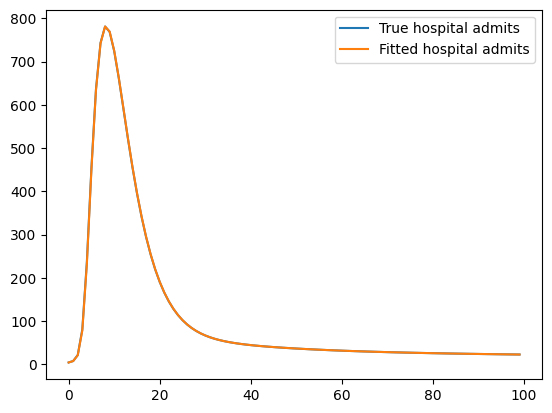

In [21]:
# Can simulate with fitted parameters and plot corresponding output
fitted_admits_history = flu.torch_simulate_hospital_admits(init_state, opt_params, precomputed, schedules, 100, 2)
ta_baseline = opt_params.beta_baseline_raw.view(L, 1, 1).expand(L, 5, 1)

plt.clf()
plt.plot(torch.sum(true_admits_history, dim=(1, 2)), label="True hospital admits")
plt.plot(torch.sum(fitted_admits_history.clone().detach(), dim=(1, 2)), label="Fitted hospital admits")
plt.legend()
plt.show()